In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import torch

from model import Agent
from unityagents import UnityEnvironment

plt.style.use('ggplot')

# Training Aent
## Initialise params (found in testing) and env

In [2]:
nn_struct = [64, 64]
gamma = 0.9
tau = 0.01

env = UnityEnvironment(file_name="Banana.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


In [3]:
# Use the default brain to get action and state space size
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# Action space
action_size = brain.vector_action_space_size

# State space 
env_info = env.reset(train_mode=True)[brain_name]
state = env_info.vector_observations[0]
state_size = len(state)

print("Action space dim: ", action_size)
print("State space dim: ", state_size)

Action space dim:  4
State space dim:  37


## Agent training function

In [4]:
def train_agent(agent, n_episodes=2000, eps_start=1.0, eps_end=0.01, eps_decay=0.995, windows=[10, 100]):
    """
    Training the agent
    """
    scores = []
    avg_score = -np.inf
    max_avg_score = -np.inf
    eps = eps_start
    start = time.perf_counter()

    win1, win2 = windows

    for i in range(n_episodes):
        info = env.reset(train_mode=True)[brain_name]
        state = info.vector_observations[0]
        score = 0 

        while True:
            action = agent.act(state, eps)            
            info = env.step(action)[brain_name]
            
            next_state = info.vector_observations[0]
            reward = info.rewards[0]
            done = info.local_done[0]
            score += reward
            
            agent.step(state, action, reward, next_state, done)

            state = next_state

            if done:
                break 

        scores.append(score)
        eps = max(eps_end, eps_decay*eps)

        if len(scores) > 99:
            avg_score = np.mean(scores[-100:])
            max_avg_score = max(avg_score, max_avg_score)
            
        now = time.perf_counter() - start
        print(f"\r{int(now/60):02d}:{int(now%60):02d} Episode {i+1}/{n_episodes}, Max Avg: {max_avg_score:.4f}, Avg: {avg_score:.4f}, Epsilon: {eps:.4f}", end="")
        
        # Set limit above requirement for good measure
        if avg_score > 15:
            print(f"\nSuccess, avg score of {avg_score:.2f} after {i} episodes")
            break 
            
    avg_1 = [np.nan for _ in range(win1 - 1)]
    avg_2 = [np.nan for _ in range(win2 - 1)]

    for i in range(len(scores) - win1 + 1):
        avg_1.append(np.mean(scores[i:i+win1]))

    for i in range(len(scores) - win2 + 1):
        avg_2.append(np.mean(scores[i:i+win2]))

    plt.plot(scores, label="Individual")
    plt.plot(avg_1, label=f"Avg_Window = {win1}")
    plt.plot(avg_2, label=f"Avg_window = {win2}")
    plt.xlabel("episode")
    plt.ylabel("score")
    plt.legend()
    plt.savefig("ouput_rewards.png")
    plt.show()

## Initialise agent and train

07:50 Episode 754/2000, Max Avg: 15.0100, Avg: 15.0100, Epsilon: 0.0228
Success, avg score of 15.01 after 753 episodes


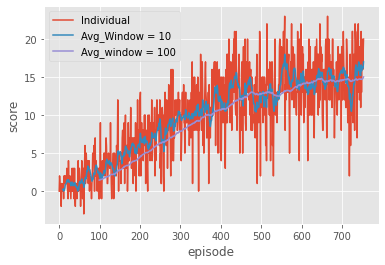

In [5]:
agent = Agent(state_size, action_size, nn_struct, gamma=gamma, tau=tau)
train_agent(agent)

## Save model and test loading

In [6]:
torch.save(agent.local_nn, "model_weights/local_nn.trch")
torch.save(agent.target_nn, "model_weights/target_nn.trch")

In [7]:
# Load into other agent
agent2 = Agent(state_size, action_size, nn_struct, gamma=gamma, tau=tau)

agent2.local_nn = torch.load("model_weights/local_nn.trch")
agent2.target_nn = torch.load("model_weights/target_nn.trch")

In [11]:
# Test it running
for i in range(2):
    info = env.reset(train_mode=False)[brain_name]
    state = info.vector_observations[0]
    score = 0
    
    while True:
        action = agent2.act(state, 0)            
        info = env.step(action)[brain_name]

        next_state = info.vector_observations[0]
        reward = info.rewards[0]
        done = info.local_done[0]
        score += reward
        
        agent2.step(state, action, reward, next_state, done)

        state = next_state

        if done:
            break 
            
    print(f"Attempt {i+1} score: {score}")

Attempt 1 score: 19.0
Attempt 2 score: 16.0
